In [1]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [2]:
import pandas as pd
from nltk import word_tokenize
from tqdm import tqdm
tqdm.pandas()

from sklearn.utils import shuffle

In [3]:
windows_path = "D:/Sync/Thesis/Datasources/Preprocessed/Combined/Taxonomy/Normal/Annotated/combined_annotations.csv"
mac_path = '/Users/ivowings/Sync/Thesis/Datasources/Preprocessed/Combined/Taxonomy/Normal/Annotated/combined_annotations.csv'

annotations = pd.read_csv(mac_path,sep=';')
annotations = shuffle(annotations,random_state=123)
annotations.head()


,left_context,candidate_skill,right_context,label
19073,assist their development enable them to become...,independent,and in turn become business mentor themselves,0
13367,excellent,understanding,of the web stack,0
19817,member handbook and offer service of a,polite,efficient and professional manner,1
9569,make them easy to use,and understand,and working with ux and,0
5291,the uncertain waters exceptional communication,skills verbal and,written highly organised,0


In [5]:
candidate_skill_split = annotations['candidate_skill'].str.split(' ',expand=True)
candidate_skill_split = candidate_skill_split.add_prefix('token_')
candidate_skill_split.head()

,token_0,token_1,token_2,token_3
19073,independent,None,None,None
13367,understanding,None,None,None
19817,polite,None,None,None
9569,and,understand,None,None
5291,skills,verbal,and,None


In [6]:
annotations = candidate_skill_split.join(annotations)
annotations.head()

,token_0,token_1,token_2,token_3,left_context,candidate_skill,right_context,label
19073,independent,None,None,None,assist their development enable them to become...,independent,and in turn become business mentor themselves,0
13367,understanding,None,None,None,excellent,understanding,of the web stack,0
19817,polite,None,None,None,member handbook and offer service of a,polite,efficient and professional manner,1
9569,and,understand,None,None,make them easy to use,and understand,and working with ux and,0
5291,skills,verbal,and,None,the uncertain waters exceptional communication,skills verbal and,written highly organised,0


In [7]:
annotations['token_0'] = annotations['token_0']+':'+annotations['label'].astype(str)
annotations['token_1'] = annotations['token_1']+':'+annotations['label'].astype(str)
annotations['token_2'] = annotations['token_2']+':'+annotations['label'].astype(str)
#annotations['token_3'] = annotations['token_3']+':'+annotations['label'].astype(str)
annotations.head()

,token_0,token_1,token_2,token_3,left_context,candidate_skill,right_context,label
19073,independent:0,NaN,NaN,None,assist their development enable them to become...,independent,and in turn become business mentor themselves,0
13367,understanding:0,NaN,NaN,None,excellent,understanding,of the web stack,0
19817,polite:1,NaN,NaN,None,member handbook and offer service of a,polite,efficient and professional manner,1
9569,and:0,understand:0,NaN,None,make them easy to use,and understand,and working with ux and,0
5291,skills:0,verbal:0,and:0,None,the uncertain waters exceptional communication,skills verbal and,written highly organised,0


In [8]:
annotations = annotations.fillna('')
#annotations['combined'] = annotations['left_context'] + ' ' + annotations['token_0'] + ' ' + annotations['token_1'] + ' '+ annotations['token_2'] + ' ' + annotations['token_3'] + ' ' + annotations['right_context']+'.'
annotations['combined'] = annotations['left_context'] + ' ' + annotations['token_0'] + ' ' + annotations['token_1'] + ' '+ annotations['token_2'] + ' ' + annotations['right_context']+'.'

annotations.head()

,token_0,token_1,token_2,token_3,left_context,candidate_skill,right_context,label,combined
19073,independent:0,,,,assist their development enable them to become...,independent,and in turn become business mentor themselves,0,assist their development enable them to become...
13367,understanding:0,,,,excellent,understanding,of the web stack,0,excellent understanding:0 of the web stack.
19817,polite:1,,,,member handbook and offer service of a,polite,efficient and professional manner,1,member handbook and offer service of a polite...
9569,and:0,understand:0,,,make them easy to use,and understand,and working with ux and,0,make them easy to use and:0 understand:0 and ...
5291,skills:0,verbal:0,and:0,,the uncertain waters exceptional communication,skills verbal and,written highly organised,0,the uncertain waters exceptional communication...


In [10]:
test = annotations[['combined']].sample(frac=0.2,random_state=123)
train = annotations.drop(test.index)
train = train[['combined']]

In [12]:
#Breaking each sentence down into tokens for annotation

def tuple_transformer(dataset):
    token_df = pd.DataFrame()

    dataset= dataset

    for index in tqdm(range(0,len(dataset['combined']))):
        tokens = pd.DataFrame(word_tokenize(dataset['combined'].iloc[index]),columns=['tokens'])
        tokens['index'] = index

        token_df = pd.concat([token_df,tokens])

    annotationcolumn = token_df['tokens'].str.split(':',expand=True)

    token_df['annotation'] = annotationcolumn[1]
    token_df['tokens'] = annotationcolumn[0]

    token_df['annotation'] = token_df['annotation'].fillna('O')
    token_df.annotation[token_df.annotation=='0'] = 'O'
    token_df.annotation[token_df.annotation=='1'] = 'Soft_Skill'
    token_df.annotation[token_df.annotation=='2'] = 'Hard_Skill'

    token_df = token_df.rename(columns={'index':'sentence'})

    token_df['tuples'] = list(zip(token_df.tokens, token_df.annotation))

    tuple_list = []
    sublist=[]
    for row in tqdm(token_df['tuples']):
        sublist.append(row)
        if row[0]=='.':
            tuple_list.append(sublist)
            sublist=[]
            next

    return tuple_list

In [13]:
train_sents = tuple_transformer(train)
#test_sents = tuple_transformer(test)

#Complete_sents = tuple_transformer(annotations[['combined']])

100%|██████████| 16669/16669 [01:52<00:00, 147.67it/s]
<ipython-input-12-0451c7c04cdb>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_df.annotation[token_df.annotation=='0'] = 'O'
<ipython-input-12-0451c7c04cdb>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_df.annotation[token_df.annotation=='1'] = 'Soft_Skill'
<ipython-input-12-0451c7c04cdb>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_df.annotation[token

In [15]:
def word2features(sent, i):
    word = sent[i][0]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word.length' : len(word),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.length' : len(word1)})
        if i-2 >= 0:
            word2 = sent[i-2][0]
            features.update({
                '-2:word.lower()': word2.lower(),
            '-2:word.length' : len(word2)})
            if i-3 >= 0:
                word3 = sent[i-3][0]
                features.update({
                    '-3:word.lower()': word3.lower(),
                '-3:word.length' : len(word3)})
        
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.length': len(word1)})
        if i < len(sent)-2:
            word2 = sent[i+2][0]
            features.update({
            '+2:word.lower()': word2.lower(),
            '+2:word.length': len(word2)})
            if i < len(sent)-3:
                word3 = sent[i+3][0]
                features.update({
                '+3:word.lower()': word3.lower(),
                '+3:word.length': len(word3)})
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

In [17]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]


X = [sent2features(s) for s in Complete_sents]
Y = [sent2labels(s) for s in Complete_sents]

CPU times: user 1.21 s, sys: 282 ms, total: 1.49 s
Wall time: 2.62 s


In [34]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 16.9 s, sys: 254 ms, total: 17.1 s
Wall time: 17.7 s


AttributeError: 'CRF' object has no attribute 'keep_tempfiles'

AttributeError: 'CRF' object has no attribute 'keep_tempfiles'

In [35]:
labels = list(crf.classes_)
#labels.remove('O')

In [36]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)


0.9707290146822388

In [37]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0], name[2:])
)


test = (metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3))

/Users/ivowings/opt/anaconda3/envs/Thesis/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'Hard_Skill', 'Soft_Skill'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [38]:
from sklearn.model_selection import KFold
folds = 10
kf = KFold(n_splits=folds)
kf.get_n_splits(X)

import numpy as np
X = np.array(X)
Y = np.array(Y)

#Cross validation CRF model
results = []

for train_index, test_index in kf.split(X):
    
    
    #break
    crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.07631744316674878,
    c2=0.04351002093874303,
    max_iterations=100,
    all_possible_transitions=True
)
    crf.fit(X[train_index], Y[train_index])
    
    y_pred = crf.predict(X[test_index])
    
    results.append(metrics.flat_classification_report(Y[test_index], y_pred, labels=sorted_labels, digits=3,output_dict=True))

final_results = pd.DataFrame()

for x in results:
    final_results = pd.DataFrame(x).T + final_results.fillna(0)

final_results/folds


<ipython-input-38-f71dc36dd3e1>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array(X)
<ipython-input-38-f71dc36dd3e1>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Y = np.array(Y)
/Users/ivowings/opt/anaconda3/envs/Thesis/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'Hard_Skill', 'Soft_Skill'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/ivowings/opt/

KeyboardInterrupt: 

In [39]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.07631744316674878,
    c2=0.04351002093874303,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)



AttributeError: 'CRF' object has no attribute 'keep_tempfiles'

AttributeError: 'CRF' object has no attribute 'keep_tempfiles'

In [44]:
from itertools import chain

f_y_test = list(chain.from_iterable(y_test))
f_pred_y = list(chain.from_iterable(crf.predict(X_test)))

In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(f_y_test, f_pred_y, labels= crf.classes_)

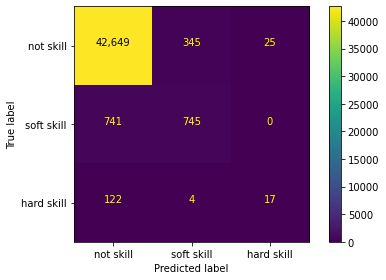

In [46]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    #plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "yellow")


    plt.tight_layout()
    plt.savefig('confusion_matrix_crf.eps', format='eps')
    plt.show()
plot_confusion_matrix(cm, 
                      normalize    = False,
                      cmap='viridis',
                      target_names = ['not skill', 'soft skill', 'hard skill'],
                      title        = "")

 

In [ ]:
#Save confusion matrix best performing model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix





plot_confusion_matrix(crf, X_test, y_test,display_labels=['soft skill', 'hard skill'])
#plt.savefig('test.eps', format='eps')
plt.show()

In [ ]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)

params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
precision_scorer = make_scorer(metrics.flat_precision_score,
                        average='macro', labels=labels)

recall_scorer = make_scorer(metrics.flat_recall_score,
                        average='macro', labels=labels)

f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='macro', labels=labels)

scoring_dict = {'Precision': precision_scorer,
               'Recall': recall_scorer,
               'F1-Score': f1_scorer}

scoring = {'recall0': make_scorer(recall_score, average = None, labels = [0]), 
       'recall1': make_scorer(recall_score, average = None, labels = [1]),
       'recall2': make_scorer(recall_score, average = None, labels = [2])}


from sklearn.model_selection import cross_validate
cross_validate(crf,X,Y, scoring = scoring_dict, cv = 2, return_train_score = False,verbose=True,n_jobs=-1)

In [ ]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

In [ ]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

In [ ]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))